<a href="https://colab.research.google.com/github/alex11marin11/Analysis-of-team-passing-networks-depending-on-the-possession-outcome/blob/main/Project_Passing_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import glob
import networkx as nx
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
passes_files = glob.glob("/content/drive/MyDrive/project/datos/*_pass.txt")
passes_files.sort()
players_files = glob.glob("/content/drive/MyDrive/project/datos/*_player.txt")
players_files.sort()
xG_files = glob.glob("/content/drive/MyDrive/project/datos/*_xG_data.txt")
xG_files.sort()
teams_files = glob.glob("/content/drive/MyDrive/project/datos/*_team.txt")
teams_files.sort()

In [3]:
def get_teams(df_passes):
    # Get list of teams
    teams = df_passes['team_id'].unique()
    return teams

def get_players(df_player,team_id):
    # Get list of players sorted by name
    players = df_player[df_player['team_id'] == team_id]['known_name'].unique()
    players.sort()
    return players
    
def build_df_passes(passes):
    df_pass = passes.copy()
    df_pass = df_pass.merge(df_player[['id','known_name']],how='left',left_on='player_id_1',right_on='id').drop('id_y',axis=1)
    df_pass.rename({'known_name':'player_name_1'},axis=1,inplace=True)
    df_pass = df_pass.merge(df_player[['id','known_name']],how='left',left_on='player_id_2',right_on='id').drop('id',axis=1)
    df_pass.rename({'known_name':'player_name_2'},axis=1,inplace=True)
    df_pass = df_pass[(df_pass['outcome']==1) & (df_pass['player_id_2']!=0)]
    return df_pass

def get_df_passes_shots(df_pass, df_xG):
    # Mix passes and shots and order by time and reset index to get new ordered ids
    df_mix = pd.concat([df_pass,df_xG])
    df_mix['period_id'].fillna(df_mix['period'],inplace=True)   # Assign same period to use column
    df_mix = df_mix.sort_values(['period_id','min','sec'])      # Sort by period first (issue with Stoppage time)
    df_mix.reset_index(inplace=True,drop=True)

    # Find the shots (null possession) and assign it the index value of the pass previous to the shot
    df_mix['possession_shot'] = np.where(df_mix['sequence'].isnull(),df_mix.index-1,0)

    # Reset index and add it as column for later check
    df_mix.reset_index(inplace=True)
    return df_mix

def get_shot_passes(df_pass, df_mix):
    # Get list of ids of passes before shot (remove 0 when still no shot in match)
    before = np.delete(df_mix['possession_shot'].unique(),0) # Id of the play before the shot

    # Get the possession numbers of the passes before the shot
    possession_num = df_mix[df_mix['index'].isin(before)]['sequence'].unique() # Possession number of the play of the shot
    possession_num = possession_num[~np.isnan(possession_num)] # remove nan: when no pass before shot e.g. two consecutive shots

    # Get passes from possessions that lead to shots
    df_passes_shot = df_pass[df_pass['sequence'].isin(possession_num)]
    return df_passes_shot

def get_passes_matrix(df_passes, players):

    # Get in Matrix format
    player_pass_count = df_passes.groupby(["player_name_1","player_name_2"]).size().to_frame("num_passes").reset_index()
    player_pass_count = player_pass_count.pivot_table(values='num_passes', index="player_name_1", columns='player_name_2')

    # Get passing matrix for all players in team (all no matter if did not play or did not pass)
    passing_matrix = pd.DataFrame(player_pass_count,columns=players,index=players).fillna(0).astype(int)
    return passing_matrix

def get_lost_ball_passes(df_pass,df_mix):

    df_mix['possession'].fillna(method='ffill',inplace=True)
    df_mix['sequence'].fillna(method='ffill',inplace=True)

    df_first_half = df_mix[df_mix['period_id']==1]      # We separate them to drop last play of each half
    df_second_half = df_mix[df_mix['period_id']==2]

    df_passes_lost = pd.DataFrame({})                   # df to join first and second half again
    for df_half in [df_first_half,df_second_half]:
        
        df_passes_lost = pd.concat([df_passes_lost,
                df_half[(df_half['sequence'] != df_half['sequence'].shift(-1)) & 
                        (df_half['possession'] != df_half['possession'].shift(-1)) &            # Select when ball lost (different sequence, possession and team)            
                        (~df_half['sequence'].isin(df_half[df_half['outcome'].isnull()]['sequence'].unique())) &  # Drop possessions end in shot
                        (df_half['index'] != max(df_half['index'])) |               # Drop last possession
                        (df_half['possession'] == 0)]])                             # Or when possesion missing (0 normally means lost)

    # Get the possession numbers of the passes before ball lost
    before_lost = df_passes_lost['sequence'].unique()

    # Get passes from possessions that lead to losing the ball
    df_passes_lost = df_pass[df_pass['sequence'].isin(before_lost)]

    return df_passes_lost

In [4]:
stats = pd.DataFrame()
for i in range(len(passes_files)):
    # Read data for specific match
    df_pass = pd.read_csv(passes_files[i],sep='\t')
    df_player = pd.read_csv(players_files[i],sep='\t')
    df_xG = pd.read_csv(xG_files[i],sep='\t')

    # Get assisting dfs
    df_passes = build_df_passes(df_pass)                            # Get df of passes cleaned and with player names
    df_mix = get_df_passes_shots(df_passes, df_xG)                  # Get df of passes & shots ordered by time

    df_passes_shot = get_shot_passes(df_passes, df_mix)             # Get passes leading to shots
    df_passes_lost = get_lost_ball_passes(df_passes, df_mix)        # Get passes leading to lost balls

    avg_position = df_passes[['start_x','start_y','player_name_1']].groupby('player_name_1').mean().reset_index()

    match_id = df_passes['match_id'].unique()[0]                    # Get match_id
    teams = get_teams(df_passes)                                    # Get list of teams in that game

    for team in teams:
        # Get list of all players in squad that played in the match
        players = get_players(df_player[df_player['minutos']>0],team)

        # Get matrices
        matrix_all = get_passes_matrix(df_passes, players)                      # Get passing matrix (All passes)
        matrix_shot = get_passes_matrix(df_passes_shot, players)                # Get passing matrix (Shot passes)
        matrix_lost = get_passes_matrix(df_passes_lost, players)                # Get passing matrix (Lost passes)
        
        # Get graphs
        graph_passes_all = nx.from_pandas_adjacency(matrix_all, create_using = nx.DiGraph)
        graph_passes_shot = nx.from_pandas_adjacency(matrix_shot, create_using = nx.DiGraph)
        graph_passes_lost = nx.from_pandas_adjacency(matrix_lost, create_using = nx.DiGraph)
        
        # Get centralities for each graph
        eigen_cent_all = list(nx.eigenvector_centrality(graph_passes_all,weight='weight').values())
        eigen_cent_shot = list(nx.eigenvector_centrality(graph_passes_shot,weight='weight',max_iter=1000).values())
        eigen_cent_lost = list(nx.eigenvector_centrality(graph_passes_lost,weight='weight').values())

        # Get num of passes done and received
        passes_done_all = matrix_all.sum(axis = 1)
        passes_received_all = matrix_all.sum()
        passes_done_shot = matrix_shot.sum(axis = 1)
        passes_received_shot = matrix_shot.sum()
        passes_done_lost = matrix_lost.sum(axis = 1)
        passes_received_lost = matrix_lost.sum()

        # Get the stats for that team in the match
        stats_match = pd.DataFrame(list(zip(players,passes_done_all,passes_received_all,passes_done_shot,passes_received_shot,
                                            passes_done_lost,passes_received_lost,eigen_cent_all,eigen_cent_shot,eigen_cent_lost)), 
                                   columns = ['Player','Passes done All','Passes received All','Passes done Shot','Passes received Shot',
                                              'Passes done Lost','Passes received Lost','eigen_cent_all','eigen_cent_shot','eigen_cent_lost'])
        df_players_player = df_player[['known_name','posicion','titular','minutos']]
        df_players_player.columns=['known_name','Position','Starting','Minutes played']
        stats_match = stats_match.merge(avg_position,how='left',left_on='Player',right_on='player_name_1').drop('player_name_1',axis=1)
        df_players_player['match_id'] = match_id
        df_players_player['team'] = df_xG[df_xG['team_receives_id']==team]['team_receives_name'].iloc[0]        # Get team name
        stats_match = stats_match.merge(df_players_player,how='inner',left_on='Player',right_on='known_name').drop('known_name',axis=1)
        
        # Add match data to df
        stats = pd.concat([stats,stats_match])

Se han truncado las últimas 5000 líneas del flujo de salida.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players_player['match_id'] = match_id
<ipython-input-4-1269d2af0a75>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players_player['team'] = df_xG[df_xG['team_receives_id']==team]['team_receives_name'].iloc[0]        # Get team name
<ipython-input-4-1269d2af0a75>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [5]:
min_played = stats[['Player','Minutes played','team']].groupby(['Player','team']).sum()
players_keep = min_played[min_played['Minutes played'] >= 90*4].reset_index()
stats_final = stats[(stats['Position']!='Goalkeeper') & ((stats['Player']+'_'+stats['team']).isin((players_keep['Player']+'_'+players_keep['team']).unique()))]

In [6]:
top10_all = stats_final.sort_values('eigen_cent_all',ascending=False).head(10)
top10_shot = stats_final.sort_values('eigen_cent_shot',ascending=False).head(10)
top10_lost = stats_final.sort_values('eigen_cent_lost',ascending=False).head(10)
top10_all

,Player,Passes done All,Passes received All,Passes done Shot,Passes received Shot,Passes done Lost,Passes received Lost,eigen_cent_all,eigen_cent_shot,eigen_cent_lost,start_x,start_y,Position,Starting,Minutes played,match_id,team
3,Gorka Guruzeta,8,32,1,4,7,23,0.707536,0.726572,0.680002,58.212500,25.337500,Striker,Start,89,2219836,Amorebieta
7,Ignasi Miquel,64,72,6,4,42,48,0.633022,0.450481,0.620718,35.482813,59.970312,Defender,Start,90,2219804,Huesca
9,Lluís López,80,84,7,7,40,41,0.614857,0.380823,0.631231,41.512500,28.407500,Defender,Start,90,2219918,Real Zaragoza
2,Aritz Arambarri,71,72,5,6,55,52,0.613937,0.556880,0.619644,39.195775,71.052113,Defender,Start,84,2219771,Real Sociedad B
1,Borja Sánchez,21,33,0,1,16,23,0.609253,0.002299,0.546298,57.161905,74.580952,Midfielder,Start,81,2220061,Real Oviedo
13,Urko González de Zárate,73,74,8,8,47,47,0.593488,0.326274,0.587253,31.300000,36.963014,Defender,Start,90,2219643,Real Sociedad B
8,Juanpe,78,85,10,8,48,57,0.592324,0.568673,0.623828,33.250000,77.042308,Defender,Start,90,2219815,Girona
8,Pablo Vázquez,77,79,9,9,49,52,0.588888,0.591315,0.573912,30.712987,40.025974,Defender,Start,90,2220032,FC Cartagena
7,Jean-Sylvain Babin,50,51,3,3,32,32,0.586357,0.199707,0.595809,32.994000,67.822000,Defender,Start,90,2220027,Sporting de Gijón
2,Aritz Arambarri,63,70,6,6,54,55,0.585391,0.336311,0.596817,36.179365,67.452381,Defender,Start,90,2219743,Real Sociedad B


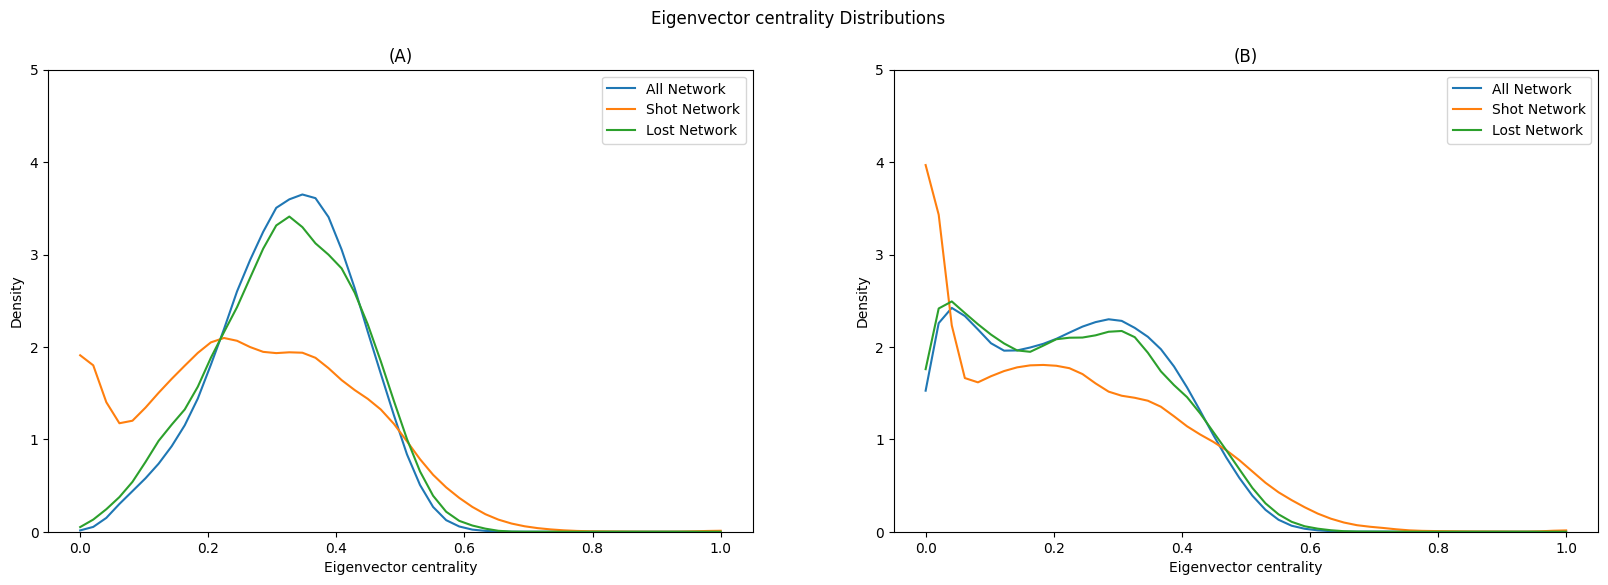

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Show distribution of all individual peformances for each type of network
stats[(stats['Position']!='Goalkeeper') & (stats['Minutes played'] == 90)][['eigen_cent_all','eigen_cent_shot','eigen_cent_lost']].plot.kde(ind=np.linspace(0, 1), ax=axes[0],)
stats_final[['eigen_cent_all','eigen_cent_shot','eigen_cent_lost']].plot.kde(ind=np.linspace(0, 1), ax=axes[1])

# Set plot properties
fig.suptitle('Eigenvector centrality Distributions')
axes[0].title.set_text('(A)')
axes[0].set(xlabel="Eigenvector centrality", ylabel="Density")
axes[0].legend(["All Network", "Shot Network", 'Lost Network'])
axes[1].title.set_text('(B)')
axes[1].set(xlabel="Eigenvector centrality", ylabel="Density")
axes[1].legend(["All Network", "Shot Network", 'Lost Network'])
plt.setp(axes, ylim=[0,5])
plt.show()

<ipython-input-8-1ea14d2ce347>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  season_player_mean = stats_final.groupby(['Player','team'])['eigen_cent_all','eigen_cent_shot','eigen_cent_lost'].agg(['mean','std'])
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


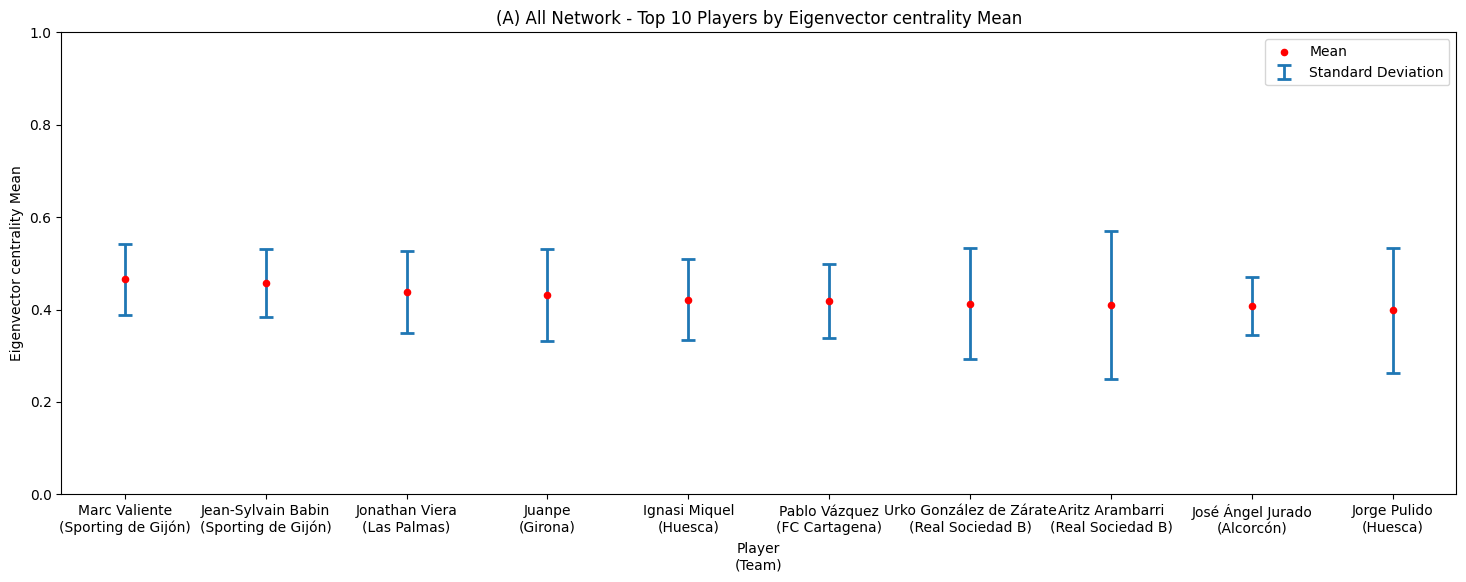

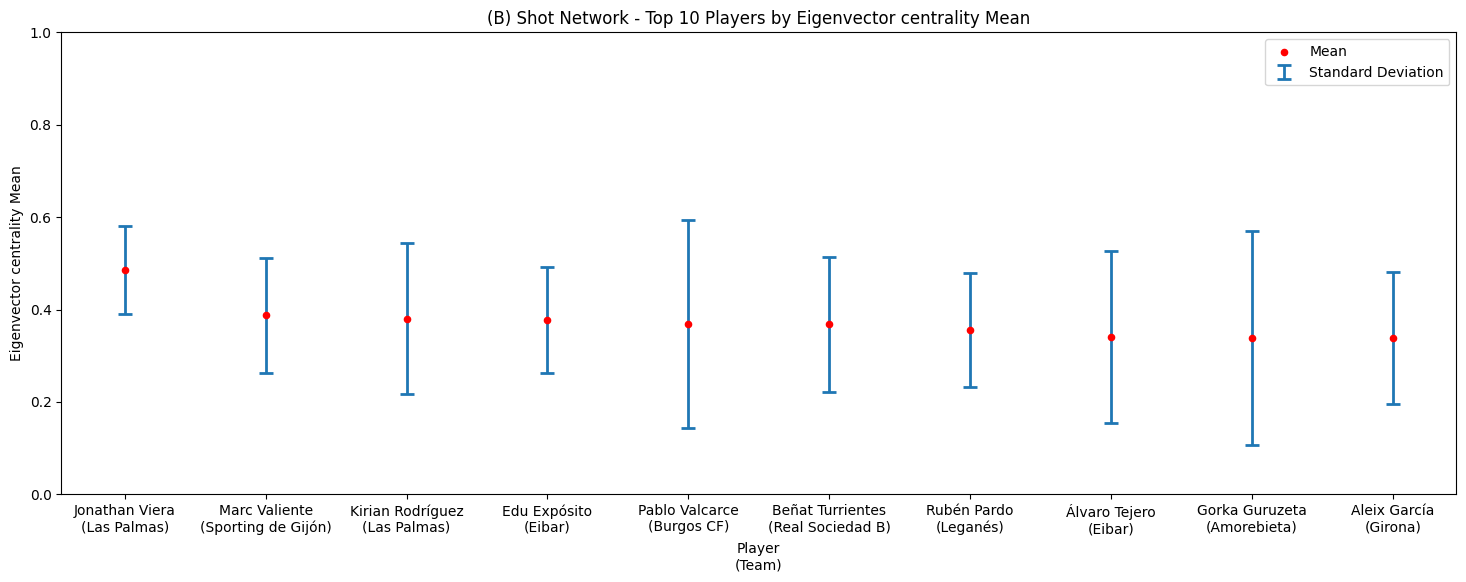

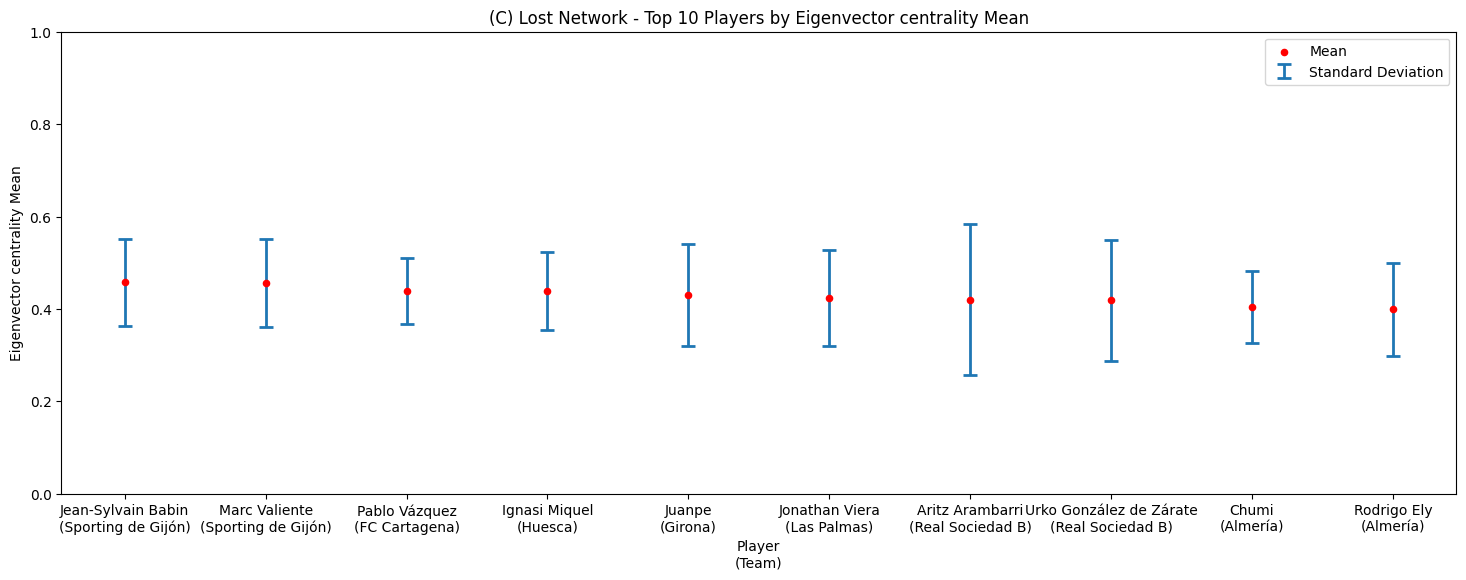

In [8]:
season_player_mean = stats_final.groupby(['Player','team'])['eigen_cent_all','eigen_cent_shot','eigen_cent_lost'].agg(['mean','std'])
season_player_mean.columns = ['_'.join(col) for col in season_player_mean.columns]
season_player_mean.index = ['\n('.join(row)+')' for row in season_player_mean.index]

df_all = season_player_mean.sort_values('eigen_cent_all_mean',ascending=False).head(10).reset_index()
df_shot = season_player_mean.sort_values('eigen_cent_shot_mean',ascending=False).head(10).reset_index()
df_lost = season_player_mean.sort_values('eigen_cent_lost_mean',ascending=False).head(10).reset_index()

ax0 = df_all.plot(kind='scatter', x='index', y='eigen_cent_all_mean', s=20, c='r', figsize=(18, 6))
ax0.errorbar(x=df_all['index'], y=df_all['eigen_cent_all_mean'],yerr=df_all['eigen_cent_all_std'], linestyle='None', lw=2, capsize=5, capthick=2, zorder=-10)

ax1 = df_shot.plot(kind='scatter', x='index', y='eigen_cent_shot_mean', s=20, c='r', figsize=(18, 6))
ax1.errorbar(x=df_shot['index'], y=df_shot['eigen_cent_shot_mean'],yerr=df_shot['eigen_cent_shot_std'], linestyle='None', lw=2, capsize=5, capthick=2, zorder=-10)

ax2 = df_lost.plot(kind='scatter', x='index', y='eigen_cent_lost_mean', s=20, c='r', figsize=(18, 6))
ax2.errorbar(x=df_lost['index'], y=df_lost['eigen_cent_lost_mean'],yerr=df_lost['eigen_cent_lost_std'], linestyle='None', lw=2, capsize=5, capthick=2, zorder=-10)

# Set plot properties
ax0.title.set_text('(A) All Network - Top 10 Players by Eigenvector centrality Mean')
ax0.set(xlabel="Player\n(Team)", ylabel="Eigenvector centrality Mean")
ax0.legend(["Mean", 'Standard Deviation'])
ax1.title.set_text('(B) Shot Network - Top 10 Players by Eigenvector centrality Mean')
ax1.set(xlabel="Player\n(Team)", ylabel="Eigenvector centrality Mean")
ax1.legend(["Mean", 'Standard Deviation'])
ax2.title.set_text('(C) Lost Network - Top 10 Players by Eigenvector centrality Mean')
ax2.set(xlabel="Player\n(Team)", ylabel="Eigenvector centrality Mean")
ax2.legend(["Mean", 'Standard Deviation'])
ax0.set_ylim([0,1])
ax1.set_ylim([0,1])
ax2.set_ylim([0,1])
plt.show()

<ipython-input-9-b592a0de6031>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_final['eigen_cent_diff'] = stats_final['eigen_cent_shot']-stats_final['eigen_cent_lost']
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


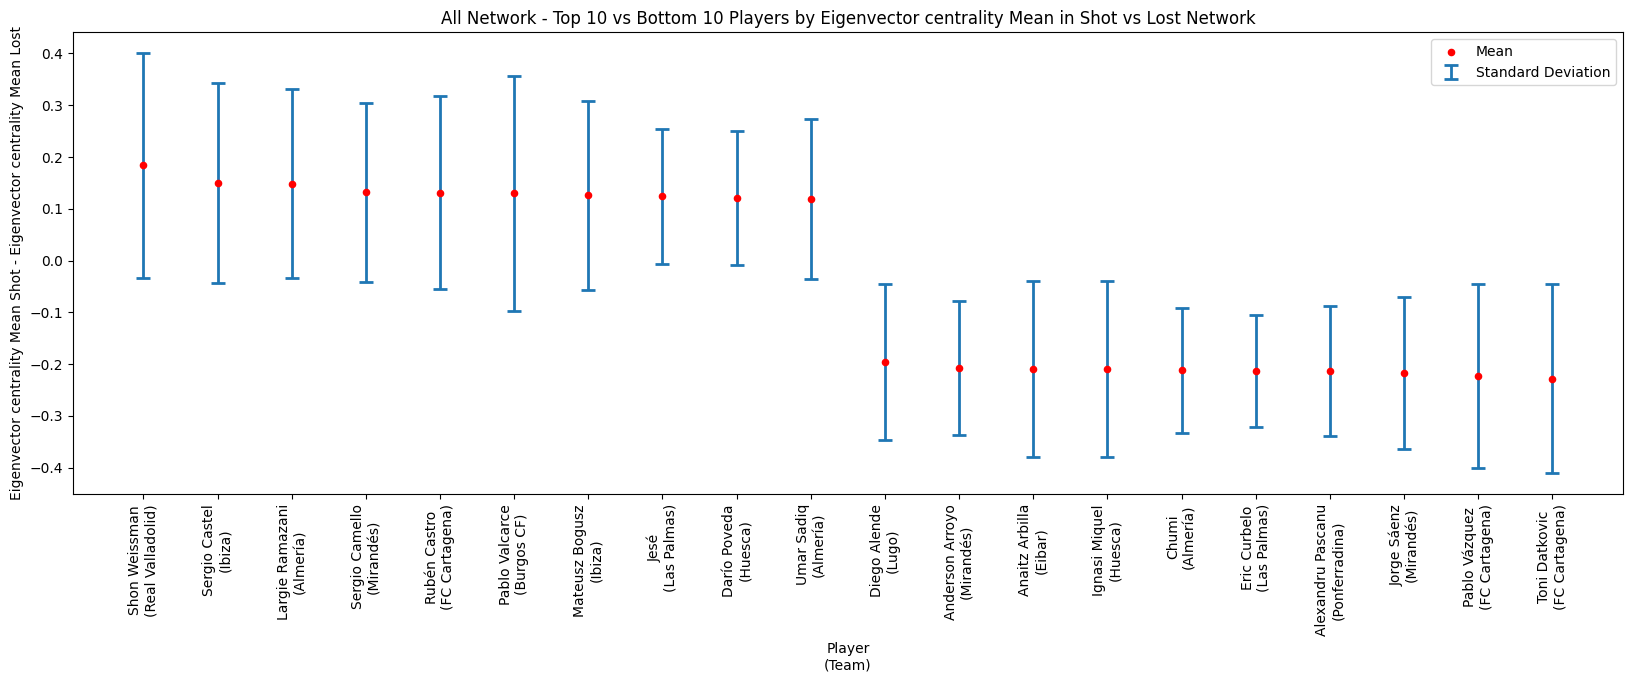

In [9]:
stats_final['eigen_cent_diff'] = stats_final['eigen_cent_shot']-stats_final['eigen_cent_lost']
diff_player_mean = stats_final.groupby(['Player','team'])["eigen_cent_diff"].agg(['mean','std']).sort_values('mean',ascending=False)
diff_player_mean.index = ['\n('.join(row)+')' for row in diff_player_mean.index]

df_diff_top10 = pd.concat([diff_player_mean.head(10),diff_player_mean.tail(10)]).reset_index()
ax0 = df_diff_top10.plot(kind='scatter', x='index', y='mean', s=20, c='r', figsize=(20, 6))
ax0.errorbar(x=df_diff_top10['index'], y=df_diff_top10['mean'],yerr=df_diff_top10['std'], linestyle='None', lw=2, capsize=5, capthick=2, zorder=-10)

# Set plot properties
ax0.title.set_text('All Network - Top 10 vs Bottom 10 Players by Eigenvector centrality Mean in Shot vs Lost Network')
ax0.set(xlabel="Player\n(Team)", ylabel="Eigenvector centrality Mean Shot - Eigenvector centrality Mean Lost")
ax0.legend(["Mean", 'Standard Deviation'])
plt.xticks(rotation=90)
plt.show()

In [49]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path, zoom=0.15):
    return OffsetImage(plt.imread(path), zoom=zoom)

paths = [
    'Alcorcon.png',
    'Almeria.png',
    'Amorebieta.png',
    'Burgos.png',
    'Eibar.png',
    'Cartagena.png',
    'Fuenlabrada.png',
    'Girona.png',
    'Huesca.png',
    'Ibiza.png',
    'LasPalmas.png',
    'Leganes.png',
    'Lugo.png',
    'Mirandes.png',
    'Malaga.png',
    'Ponferradina.png',
    'Oviedo.png',
    'RealSociedad.png',
    'RealValladolid.png',
    'RealZaragoza.png',
    'RealSporting.png',
    'Tenerife.png']

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


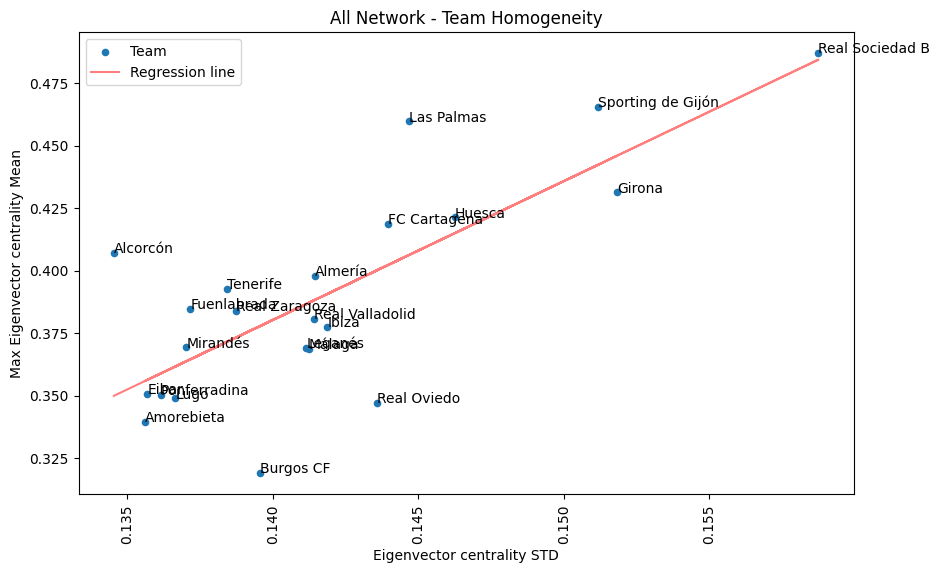

In [50]:
team_season_stats = stats[stats['Position']!='Goalkeeper'][['Player','team','eigen_cent_all']].groupby(['team']).std()
team_season_stats['max_mean_eigen_cent_all'] = stats[stats['Position']!='Goalkeeper'][['Player','team','eigen_cent_all']].groupby(['Player','team']).mean().groupby('team').max()
ax = team_season_stats.plot.scatter(x = 'eigen_cent_all', y = 'max_mean_eigen_cent_all',figsize=(10, 6))

for i in range(len(team_season_stats)):
    plt.annotate(team_season_stats.reset_index()['team'].iloc[i], (team_season_stats['eigen_cent_all'].iloc[i], team_season_stats['max_mean_eigen_cent_all'].iloc[i]))

#obtain m (slope) and b(intercept) of linear regression line
x, y = team_season_stats['eigen_cent_all'], team_season_stats['max_mean_eigen_cent_all']
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, c='r',alpha=0.5)

# Set plot properties
plt.title('All Network - Team Homogeneity')
ax.set(xlabel="Eigenvector centrality STD", ylabel="Max Eigenvector centrality Mean")
ax.legend(['Team','Regression line'])
plt.xticks(rotation=90)
plt.show()

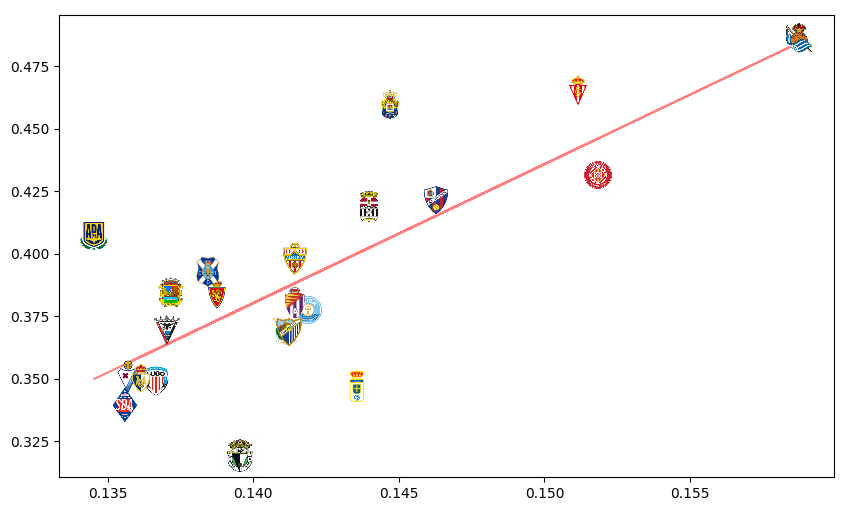

In [54]:
fig, ax = plt.subplots(figsize=(10, 6))

#obtain m (slope) and b(intercept) of linear regression line
x, y = team_season_stats['eigen_cent_all'], team_season_stats['max_mean_eigen_cent_all']
ax.scatter(x, y) 
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, c='r',alpha=0.5)

for x0, y0, path in zip(x, y,paths):
    ab = AnnotationBbox(getImage('/content/drive/MyDrive/project/logos/'+path), (x0, y0), frameon=False)
    ax.add_artist(ab)

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


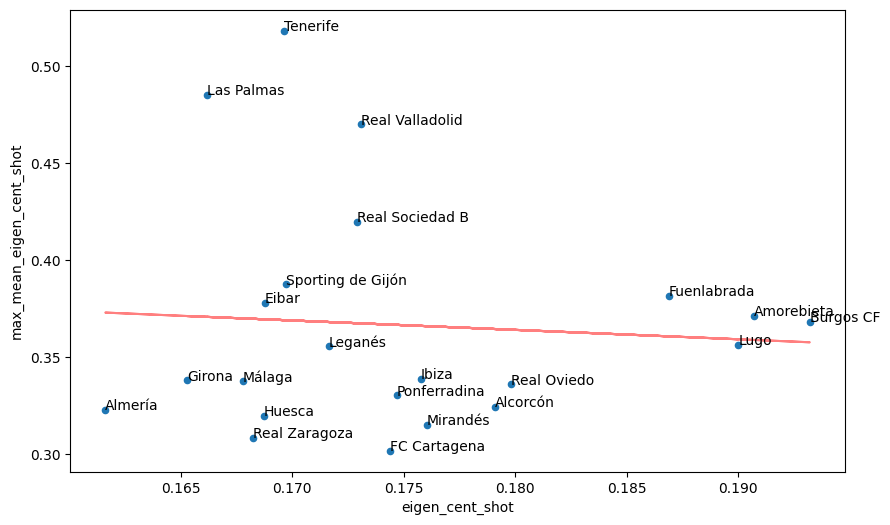

In [56]:
team_season_stats = stats[stats['Position']!='Goalkeeper'][['Player','team','eigen_cent_shot']].groupby(['team']).std()
team_season_stats['max_mean_eigen_cent_shot'] = stats[stats['Position']!='Goalkeeper'][['Player','team','eigen_cent_shot']].groupby(['Player','team']).mean().groupby('team').max()
ax = team_season_stats.plot.scatter(x = 'eigen_cent_shot', y = 'max_mean_eigen_cent_shot',figsize=(10, 6))

for i in range(len(team_season_stats)):
    plt.annotate(team_season_stats.reset_index()['team'].iloc[i], (team_season_stats['eigen_cent_shot'].iloc[i], team_season_stats['max_mean_eigen_cent_shot'].iloc[i]))

#obtain m (slope) and b(intercept) of linear regression line
x, y = team_season_stats['eigen_cent_shot'], team_season_stats['max_mean_eigen_cent_shot']
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, c='r',alpha=0.5)

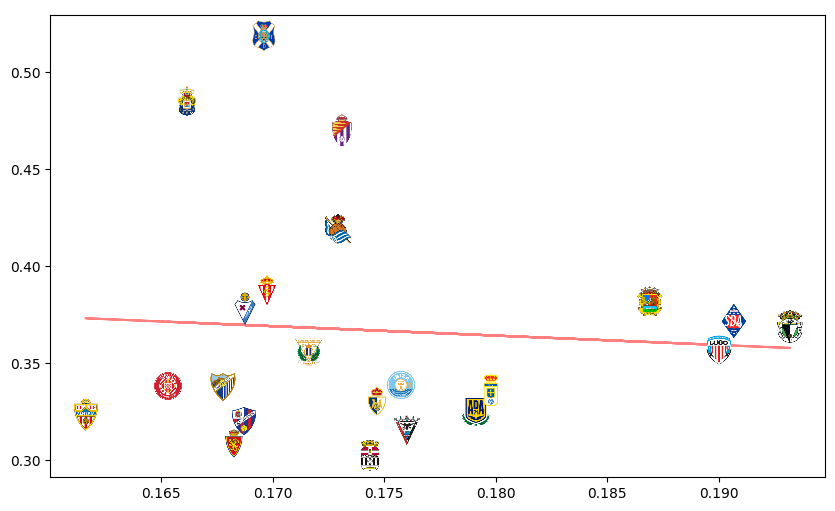

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))

#obtain m (slope) and b(intercept) of linear regression line
x, y = team_season_stats['eigen_cent_shot'], team_season_stats['max_mean_eigen_cent_shot']
ax.scatter(x, y) 
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, c='r',alpha=0.5)

for x0, y0, path in zip(x, y,paths):
    ab = AnnotationBbox(getImage('/content/drive/MyDrive/project/logos/'+path), (x0, y0), frameon=False)
    ax.add_artist(ab)

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


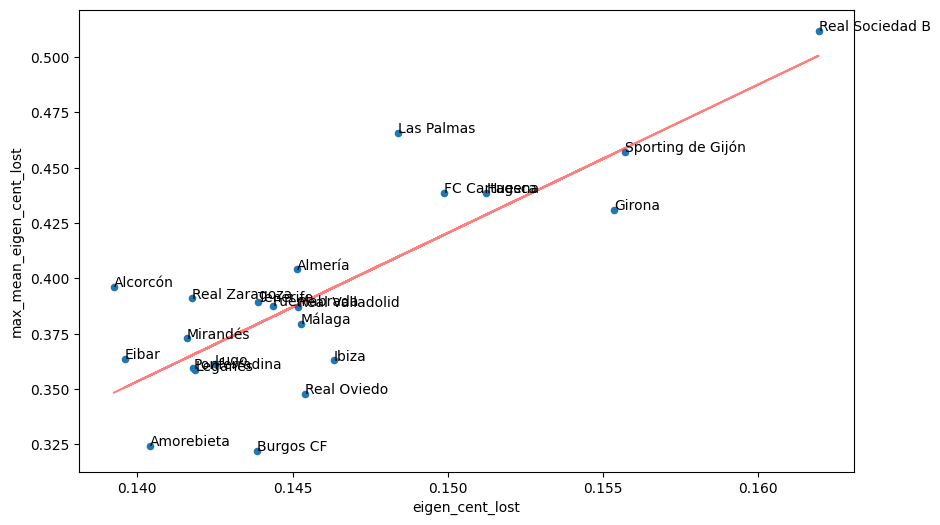

In [59]:
team_season_stats = stats[stats['Position']!='Goalkeeper'][['Player','team','eigen_cent_lost']].groupby(['team']).std()
# team_season_stats.index = ['\n('.join(row)+')' for row in team_season_stats.index]
team_season_stats['max_mean_eigen_cent_lost'] = stats[stats['Position']!='Goalkeeper'][['Player','team','eigen_cent_lost']].groupby(['Player','team']).mean().groupby('team').max()
ax = team_season_stats.plot.scatter(x = 'eigen_cent_lost', y = 'max_mean_eigen_cent_lost',figsize=(10, 6))

for i in range(len(team_season_stats)):
    plt.annotate(team_season_stats.reset_index()['team'].iloc[i], (team_season_stats['eigen_cent_lost'].iloc[i], team_season_stats['max_mean_eigen_cent_lost'].iloc[i]))

# Obtain m (slope) and b(intercept) of linear regression line
x, y = team_season_stats['eigen_cent_lost'], team_season_stats['max_mean_eigen_cent_lost']
m, b = np.polyfit(x, y, 1)

# Add linear regression line to scatterplot 
plt.plot(x, m*x+b, c='r',alpha=0.5)

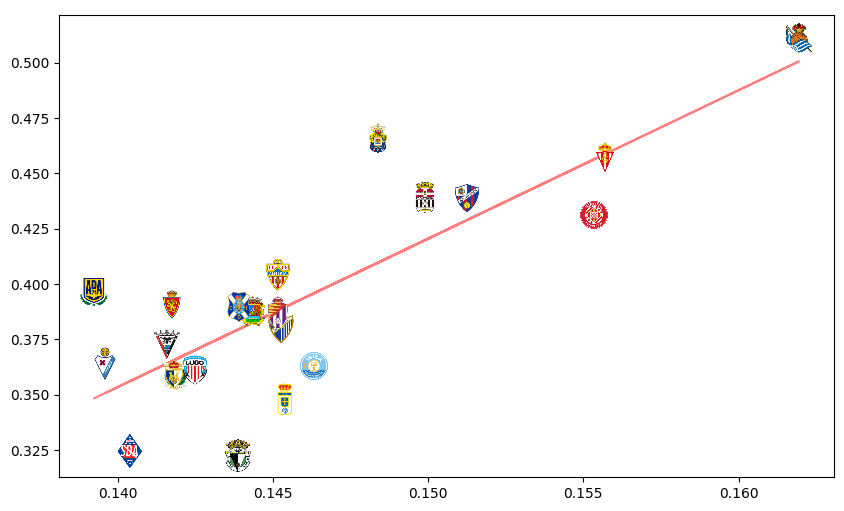

In [60]:
fig, ax = plt.subplots(figsize=(10, 6))

#obtain m (slope) and b(intercept) of linear regression line
x, y = team_season_stats['eigen_cent_lost'], team_season_stats['max_mean_eigen_cent_lost']
ax.scatter(x, y) 
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, c='r',alpha=0.5)

for x0, y0, path in zip(x, y,paths):
    ab = AnnotationBbox(getImage('/content/drive/MyDrive/project/logos/'+path), (x0, y0), frameon=False)
    ax.add_artist(ab)

In [13]:
# Draw a passing network

from matplotlib.colors import Normalize
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np

In [14]:
config = {
  "background_color": "white",
  "lines_color": "#bcbcbc",
  "edges_cmap": "Oranges",
  "nodes_cmap": "Reds",
  "font_color": "black",

  "plot_edges": "TRUE",
  "fig_size": 12,
  "font_size": 9,
  "width": 105,
  "height": 68,

  "max_node_size": 100,
  "min_node_size": 25,
  "max_edge_width": 5,
  "min_edge_width": 1
}

height = float(config["height"])
width = float(config["width"])

In [15]:
def _point_to_meters(p):
    '''
    Convert a point's coordinates from a 0-1 range to meters.
    '''
    return np.array([p[0]*width, p[1]*height])


def _meters_to_point(p):
    '''
    Convert a point's coordinates from meters to a 0-1 range.
    '''
    return np.array([p[0]/width, p[1]/height])


def _change_range(value, old_range, new_range):
    '''
    Convert a value from one range to another one, maintaining ratio.
    '''
    return ((value-old_range[0]) / (old_range[1]-old_range[0])) * (new_range[1]-new_range[0]) + new_range[0]


def draw_pitch(min_x=0, max_x=1):
    """
    Plot an empty horizontal football pitch, returning Matplotlib's ax object so we can keep adding elements to it.
    Parameters
    -----------
        min_x: float value from 0 to 'max_x' to choose a subsection of the pitch. Default value is 0.
        max_x: float value from 'min_x' to 1 to choose a subsection of the pitch. Default value is 1.
    Returns
    -----------
       ax : Matplotlib's axis object to keetp adding elements on the pitch.
    """
    background_color = config["background_color"]
    lines_color = config["lines_color"]
    fig_size = config["fig_size"]

    # This allows to plot a subsection of the pitch
    ratio = height / float((width * max_x)-(width * min_x))
    f, ax = plt.subplots(1, 1, figsize=(fig_size, fig_size*ratio), dpi=100)

    ax.set_ylim([0, height])
    ax.set_xlim([width*min_x, width*max_x])
    ax.add_patch(patches.Rectangle((0, 0), width, height, color=background_color))

    # Plot outer lines
    line_pts = [
        [_point_to_meters([0, 0]), _point_to_meters([0, 1])],  # left line
        [_point_to_meters([1, 0]), _point_to_meters([1, 1])],  # right line
        [_point_to_meters([0, 1]), _point_to_meters([1, 1])],  # top line
        [_point_to_meters([0, 0]), _point_to_meters([1, 0])],  # bottom line
    ]

    for line_pt in line_pts:
        ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-',
                alpha=0.8, lw=1.5, zorder=3, color=lines_color)

    # Plot boxes
    line_pts = [
        [_point_to_meters([0.5, 0]), _point_to_meters([0.5, 1])],  # center line

        # left box
        [[0, 24.85], [0, 2.85]],
        [[0, 13.85], [16.5, 13.85]],
        [[0, 54.15], [16.5, 54.15]],
        [[16.5, 13.85], [16.5, 54.15]],

        # left goal
        [[0, 24.85], [5.5, 24.85]],
        [[0, 43.15], [5.5, 43.15]],
        [[5.5, 24.85], [5.5, 43.15]],

        # right box
        [[105, 24.85], [105, 2.85]],
        [[105, 13.85], [88.5, 13.85]],
        [[105, 54.15], [88.5, 54.15]],
        [[88.5, 13.85], [88.5, 54.15]],

        # right goal
        [[105, 24.85], [99.5, 24.85]],
        [[105, 43.15], [99.5, 43.15]],
        [[99.5, 24.85], [99.5, 43.14]]
    ]

    for line_pt in line_pts:
        ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-',
                alpha=0.8, lw=1.5, zorder=3, color=lines_color)

    # Plot circles
    ax.add_patch(patches.Wedge((94.0, 34.0), 9, 130, 230, fill=True, edgecolor=lines_color,
                               facecolor=lines_color, zorder=4, width=0.02, alpha=0.8))

    ax.add_patch(patches.Wedge((11.0, 34.0), 9, 310, 50, fill=True, edgecolor=lines_color,
                               facecolor=lines_color, zorder=4, width=0.02, alpha=0.8))

    ax.add_patch(patches.Wedge((52.5, 34), 9.5, 0, 360, fill=True, edgecolor=lines_color,
                               facecolor=lines_color, zorder=4, width=0.02, alpha=0.8))

    plt.axis('off')
    return ax

In [16]:
def draw_pass_map(ax, player_position,
                  player_pass_count, player_pass_value, pair_pass_count, pair_pass_value, title="", legend="",
                  max_player_count=None, max_player_value=None, max_pair_count=None, max_pair_value=None):
    """
    Plot a passing network.
    Parameters
    -----------
        ax: Matplotlib's axis object, it expects to have the pitch already plotted.
        player_position: pandas DataFrame with player names as index and columns 'origin_pos_x' and 'origin_pos_y' in 0-1 range.
        player_pass_count: pandas DataFrame with player names as index and a column 'num_passes'.
        player_pass_value: pandas DataFrame with player names as index and a column 'pass_value'.
        pair_pass_count: pandas DataFrame with 'player1_player2' as index and a column 'num_passes'.
        pair_pass_value: pandas DataFrame with 'player1_player2' as index and a column 'pass_value'.
        title: text that will be shown above the pitch.
        legend: text that will be shown in the bottom-left corner of the pitch.
        max_player_count: max number of passes per player. If not specified, it uses the player_pass_count.num_passes.max()
        max_player_value: max pass value per player. If not specified, it uses the player_pass_value.pass_value.max()
        max_pair_count: max number of passes per player pair. If not specified, it uses the pair_pass_count.num_passes.max()
        max_pair_value: max pass value per player pair. If not specified, it uses the pair_pass_value.pass_value.max()
    Returns
    -----------
       ax : Matplotlib's axis object to keep adding elements on the pitch.
    """
    background_color = config["background_color"]

    player_position["origin_pos_y"] = player_position["origin_pos_y"]
    player_position["origin_pos_x"] = player_position["origin_pos_x"]

    # This allows to fix the range of sizes and color scales so that two plots from different teams are comparable.
    max_player_count = player_pass_count.num_passes.max() if max_player_count is None else max_player_count
    max_player_value = player_pass_value.pass_value.max() if max_player_value is None else max_player_value
    max_pair_count = pair_pass_count.num_passes.max() if max_pair_count is None else max_pair_count
    max_pair_value = pair_pass_value.pass_value.max() if max_pair_value is None else max_pair_value

    # Step 1: plot edges
    if config["plot_edges"]:
        # Combine num_passes and pass_value columns into one DataFrame
        pair_stats = pd.merge(pair_pass_count, pair_pass_value, left_index=True, right_index=True)
        for pair_key, row in pair_stats.iterrows():
            player1, player2 = pair_key.split("_")

            player1_x = player_position.loc[player1]["origin_pos_x"]
            player1_y = player_position.loc[player1]["origin_pos_y"]

            player2_x = player_position.loc[player2]["origin_pos_x"]
            player2_y = player_position.loc[player2]["origin_pos_y"]

            num_passes = row["num_passes"]
            pass_value = row["pass_value"]

            line_width = _change_range(num_passes, (0, max_pair_count), (config["min_edge_width"], config["max_edge_width"]))
            norm = Normalize(vmin=0, vmax=max_pair_value)
            edge_cmap = cm.get_cmap(config["nodes_cmap"])
            edge_color = edge_cmap(norm(pass_value))

            ax.plot([player1_x, player2_x], [player1_y, player2_y],
                    'w-', linestyle='-', alpha=1, lw=line_width, zorder=3, color=edge_color)

    # Step 2: plot nodes
    # Combine num_passes and pass_value columns into one DataFrame
    player_stats = pd.merge(player_pass_count, player_pass_value, left_index=True, right_index=True)
    for player_name, row in player_stats.iterrows():
        player_x = player_position.loc[player_name]["origin_pos_x"]
        player_y = player_position.loc[player_name]["origin_pos_y"]

        num_passes = row["num_passes"]
        pass_value = row["pass_value"]

        marker_size = _change_range(num_passes, (0, max_player_count), (config["min_node_size"], config["max_node_size"]))
        norm = Normalize(vmin=0, vmax=max_player_value)
        node_cmap = cm.get_cmap(config["nodes_cmap"])
        node_color = node_cmap(norm(pass_value))

        ax.plot(player_x, player_y, '.', color=node_color, markersize=marker_size, zorder=5)
        ax.plot(player_x, player_y, '.', color=background_color, markersize=marker_size-20, zorder=6)
        ax.annotate(player_name, xy=(player_x, player_y), ha="center", va="center", zorder=7,
                    fontsize=config["font_size"], color=config["font_color"], weight='bold',
                    path_effects=[pe.withStroke(linewidth=2, foreground=background_color)])

    # Step 3: Extra information shown on the plot
    #ax.annotate("Per si volem escriure algo", xy=(0.99*width, 0.02*height),
                #ha="right", va="bottom", zorder=7, fontsize=10, color=config["lines_color"])

    if legend:
        ax.annotate(legend, xy=(0.01*width, 0.02*height),
                    ha="left", va="bottom", zorder=7, fontsize=10, color=config["lines_color"])

    if title:
        ax.set_title(title, loc="center")

    return ax

In [18]:
df_pass = pd.read_csv('/content/drive/MyDrive/project/datos/2219771_pass.txt',sep='\t')
df_player = pd.read_csv('/content/drive/MyDrive/project/datos/2219771_player.txt',sep='\t')
df_teams = pd.read_csv('/content/drive/MyDrive/project/datos/2219771_team.txt',sep='\t') # RealSociedadB_id = 3567
df_passes = build_df_passes(df_pass)
df_passes = df_passes[df_passes['team_id'] == 3567]

In [19]:
# Remove Javier Martón
df_passes = df_passes[~(df_passes["player_name_2"] == "Javier Martón")]
df_passes["pass_recipient_name"] = df_passes["player_name_2"]
df_passes["player_name"] = df_passes["player_name_1"]
df_passes["origin_pos_x"] = df_passes["start_x"]*width/100
df_passes["origin_pos_y"] = df_passes["start_y"]*height/100
player_position = df_passes.groupby("player_name").agg({"origin_pos_x": "mean", "origin_pos_y": "mean"})

In [20]:
player_pass_count = df_passes.groupby("player_name").size().to_frame("num_passes")
player_pass_count['num_passes'] = list(stats[(stats['match_id'] == 2219771) & (stats['team'] == "Real Sociedad B")].drop(7)['eigen_cent_all'])
# num passes es el valor de la centralidad ahora
player_pass_value = df_passes.groupby("player_name").size().to_frame("pass_value") # pass value es el número de pases

In [21]:
df_passes["pair_key"] = df_passes.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
pair_pass_count = df_passes.groupby("pair_key").size().to_frame("num_passes")
pair_pass_value = df_passes.groupby("pair_key").size().to_frame("pass_value")

<ipython-input-15-17283ee7b1a3>:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w-" (-> color='w'). The keyword argument will take precedence.
  ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-',
<ipython-input-15-17283ee7b1a3>:85: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w-" (-> color='w'). The keyword argument will take precedence.
  ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-',
<ipython-input-16-427bf182d706>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edge_cmap = cm.get_cmap(config["nodes_cmap"])
<ipython-input-16-427bf182d706>:56: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "w-" (-> linesty

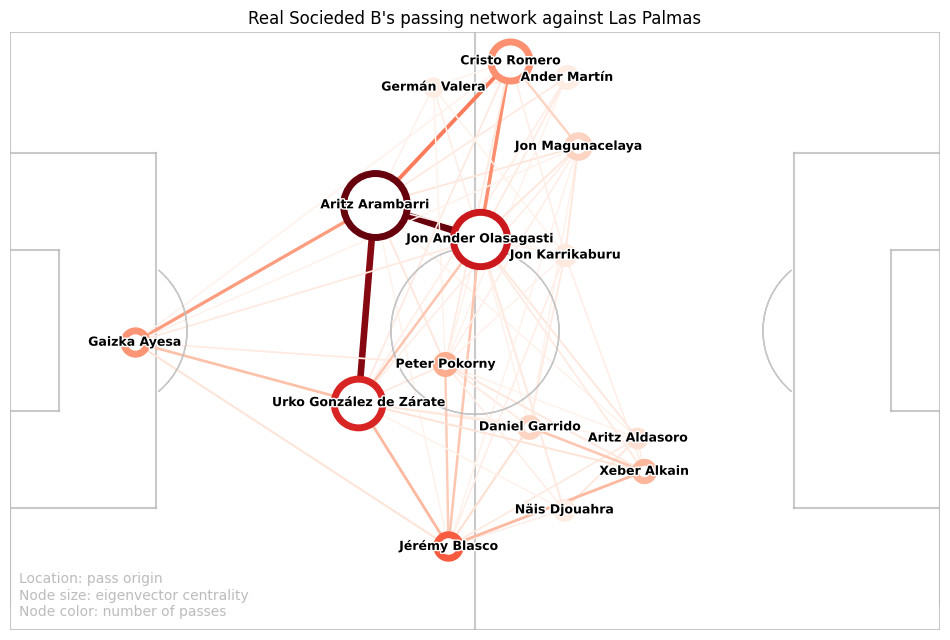

In [22]:
plot_title ="Real Socieded B's passing network against Las Palmas"

plot_legend = "Location: pass origin\nNode size: eigenvector centrality\nNode color: number of passes"

ax = draw_pitch()
ax = draw_pass_map(ax, player_position, player_pass_count, player_pass_value,
              pair_pass_count, pair_pass_value, plot_title, plot_legend)

plt.savefig("/content/drive/MyDrive/project/plot1.png")

In [23]:
max_centr_partido = stats.groupby("match_id")["eigen_cent_all"].max()

In [24]:
df_pass = pd.read_csv('/content/drive/MyDrive/project/datos/2220040_pass.txt',sep='\t')
df_player = pd.read_csv('/content/drive/MyDrive/project/datos/2220040_player.txt',sep='\t')
df_teams = pd.read_csv('/content/drive/MyDrive/project/datos/2220040_team.txt',sep='\t') # Real Zaragoza_id = 190
df_passes = build_df_passes(df_pass)
df_passes = df_passes[df_passes['team_id'] == 190]

In [25]:
df_passes["pass_recipient_name"] = df_passes["player_name_2"]
df_passes["player_name"] = df_passes["player_name_1"]
df_passes["origin_pos_x"] = df_passes["start_x"]*width/100
df_passes["origin_pos_y"] = df_passes["start_y"]*height/100
player_position = df_passes.groupby("player_name").agg({"origin_pos_x": "mean", "origin_pos_y": "mean"})

In [26]:
player_pass_count = df_passes.groupby("player_name").size().to_frame("num_passes")
player_pass_count['num_passes'] = list(stats[(stats['match_id'] == 2220040) & (stats['team'] == "Real Zaragoza")]['eigen_cent_all'])
# num passes es el valor de la centralidad ahora
player_pass_value = df_passes.groupby("player_name").size().to_frame("pass_value") # pass value es el número de pases

In [27]:
df_passes["pair_key"] = df_passes.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
pair_pass_count = df_passes.groupby("pair_key").size().to_frame("num_passes")
pair_pass_value = df_passes.groupby("pair_key").size().to_frame("pass_value")

<ipython-input-15-17283ee7b1a3>:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w-" (-> color='w'). The keyword argument will take precedence.
  ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-',
<ipython-input-15-17283ee7b1a3>:85: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w-" (-> color='w'). The keyword argument will take precedence.
  ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-',
<ipython-input-16-427bf182d706>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edge_cmap = cm.get_cmap(config["nodes_cmap"])
<ipython-input-16-427bf182d706>:56: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "w-" (-> linesty

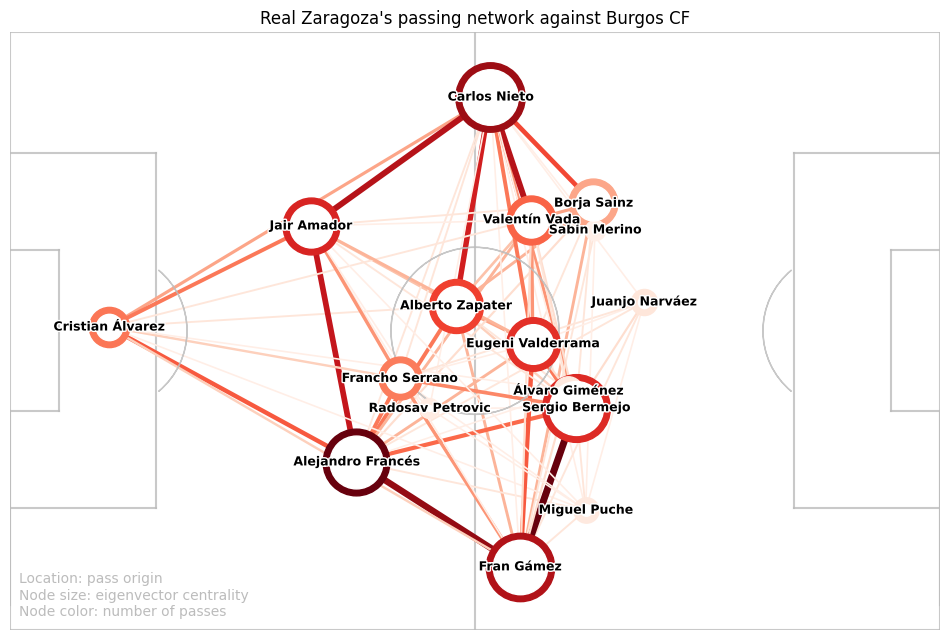

In [28]:
plot_title ="Real Zaragoza's passing network against Burgos CF"

plot_legend = "Location: pass origin\nNode size: eigenvector centrality\nNode color: number of passes"

ax = draw_pitch()
ax = draw_pass_map(ax, player_position, player_pass_count, player_pass_value,
              pair_pass_count, pair_pass_value, plot_title, plot_legend)

plt.savefig("/content/drive/MyDrive/project/plot2.png")